In [1]:
import numpy
import sklearn
%matplotlib inline

# Learning curves and error bounds

In this exercise, we test the performance of a classifier as we vary its complexity and the number of data points used for training, and compare the error with two bounds: the Hoeffdings bound, and the VC bound. As a first step, we load some artificial dataset where the two classes are 1000-dimensional Gaussians of same (isotropic) covariance and of different means.

In [2]:
import utils
X,T = utils.getdata()
print(X.shape,T.shape)

(20000, 1000) (20000,)


We consider the perceptron as a training algorithm.

In [3]:
import sklearn.linear_model
model = sklearn.linear_model.Perceptron

### Measuring the error (15 P)

The first task is to build a function that estimates the classification error (the 0/1 loss) when training the data on $N$ examples (sampled randomly from the dataset), and observing only the first $d$ dimensions of the data. Your function should output the training error and the test error (measured on the points that have not been used for training). In order to get robust error estimates, run the procedure 10 times with different training/test splits, and compute the average training and test error over the 10 splits.

In [4]:
from sklearn.metrics import zero_one_loss

def loss_0_1(fx, y):
    loss = numpy.array([fx[i] == y[i] for i in range(fx.shape[0])])
    return numpy.where(loss == True, 0, 1).mean()
    #loss = numpy.array([0 if fx[i]*y[i]>0 else 1 for i in range(fx.shape[0])])
    #return loss.mean()
    
def pick_dataset(X, T, training_size):
    #shuffle the dataset 
    index = numpy.arange(X.shape[0])
    numpy.random.shuffle(index)
    X = X[index]
    T = T[index]
    
    #particionate the dataset
    X_training = X[:training_size]
    Y_training = T[:training_size]
    X_testing = X[training_size:]
    Y_testing = T[training_size:]
    
    return X_training, Y_training, X_testing, Y_testing
    

def execute_model(model_instance, x, T, N):
    X_training, Y_training, X_testing, Y_testing = pick_dataset(x, T, N)
    
    f = model_instance.fit(X=X_training, y=Y_training)

    fx_training = f.predict(X_training)
    fx_testing = f.predict(X_testing)

    return loss_0_1(fx_training, Y_training), loss_0_1(fx_testing, Y_testing)
    #return f.score(X_training, Y_training), loss_0_1(fx_testing, Y_testing)
    
def geterr(N,d,X,T):
    x = X[:, :d]
    instance = model()
    errors = numpy.array([ execute_model(instance, x, T, N) for i in range(10)]).mean(axis=0)
    etrain,etest = errors[0], errors[1]
    return etrain,etest

### Bounding the test error (15 P)

We would like to compare the test error estimates with error bounds seen during the lecture. We consider in particular the Hoeffding's bound given by
$$
R[f] \leq R_\text{emp}[f] + \sqrt{\frac{\log(2/\delta)}{2N}}
$$
which makes the assumption that the function $f$ was not learned, but predefined. Note that this assumption does not hold in practice, and we therefore expect the Hoeffding's bound to not be a bound of the test error. We will verify this in the subsequent experiments.

We also consider the VC bound, which does not have this limitation and is therefore a true bound of the test error. The VC bound is given by:
$$
R[f] \leq  R_\text{emp}[f] + 2\sqrt{2 \frac{h_\mathcal{F} (\log (2N / h_\mathcal{F}) + 1) + \log(2/\delta)}{N}}
$$
where $h_\mathcal{F}$ is the VC-dimension that measures the model complexity, and we recall that $h_\mathcal{F} = d+1$ for the set of linear models.

In the following, we would like to implement these two bounds, so that they can be compared to the test error.

In [5]:
sqrt = numpy.sqrt
log = numpy.log

def Remp_f(errors):
    return numpy.mean(errors)
    

def hoeffding(Etrain,N,delta=0.05):
    
    constant = sqrt(log(2/delta)/(2*N))
    
    return Remp_f(Etrain) + constant

def vc(Etrain,N,d,delta=0.05):
    hf = d + 1
    
    frac_top = hf * (log(2*N/hf) + 1) + log(2/delta)
    
    constant = 2 * sqrt(2*(frac_top)/N)
    
    return Remp_f(Etrain) + constant


Once these functions have been implemented, test your implementation by running the following two experiments, where we plot the training and test error and the two bounds when varying different parameters.

In the first experiment, we first keep the number of observed dimensions $d$ fixed and vary the number of data points $N$ used for training.

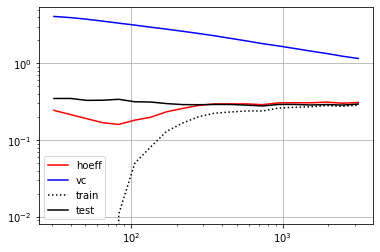

In [6]:
Ns = numpy.logspace(1.5,3.5,20).astype('int')
utils.getcurves(X,T,zip(Ns,[50]*len(Ns)),Ns,geterr,hoeffding,vc)

We observe that the Hoeffding's bound is indeed for some values of $N$ below the test error. Therefore, it is not a bound of the test error. Instead, the VC bound is always above the test error. While the bound is loose (it never actually reaches an error below 1) it still correctly predicts the benefit of including more data for improving the test error.

In the second experiment, we keep the number of training points $N$ fixed and we vary the number of dimensions $d$ used for training.

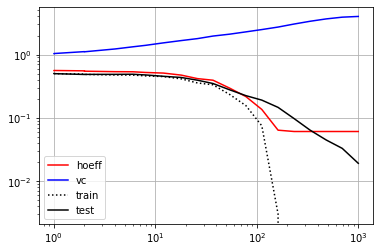

In [7]:
ds = numpy.logspace(0,3,20).astype('int')
utils.getcurves(X,T,zip([500]*len(ds),ds),ds,geterr,hoeffding,vc)

Here again, the Hoeffding's bound is not a bound of the test error as it produces values below that error. Here, the VC bound varies in opposite direction to the test error. This can be due to the fact that we have set the VC-dimension to that of a general $d$-dimensional classifier, without taking in to account other aspects such as margin, which has a tendency to increase as we observe more dimensions.